## Step 0: Imports

In [1]:
from gerrychain import (GeographicPartition, 
                        Partition, 
                        Graph, 
                        MarkovChain,
                        proposals, 
                        updaters, 
                        constraints, 
                        accept, 
                        Election)
from gerrychain.constraints import (single_flip_contiguous, 
                                    no_more_discontiguous,
                                    Validator)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import propose_random_flip, recom
from gerrychain.accept import always_accept

import pandas as pd
import numpy as np
import seaborn as sns
import math

import matplotlib.pyplot as plt
from functools import partial

import networkx as nx
import maup
import geopandas

import gerrychain

import random

In [2]:
pd.options.display.max_columns = None
%matplotlib inline

## Step 1: Setting up the initial districting plan

### Generating a graph to be partitioned

In [6]:
graph = Graph.from_file("VA_precincts_cleaned/va.shp")

/usr/local/anaconda3/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(892, 914), (893, 915), (887, 892), (887, 893)}
  overlaps


### Setting up election data

In [7]:
# Configure Election objects representing 
# some of the election data from shapefile
elections = [
    # Number of votes for 2018 senate candidate
    Election("SEN18", {"Democratic": "G18DSEN", 
                       "Republican": "G18RSEN",
                       "Other": "G18OSEN"}),
    # Number of votes for 2017 gubernatorial candidate
    Election("GOV17", {"Democratic": "G17DGOV", 
                       "Republican": "G17RGOV",
                       "Other": "G17OGOV"}),
    # Number of votes for 2016 presidential candidate
    Election("PRES16", {"Democratic": "G16DPRS", 
                        "Republican": "G16RPRS",
                        "Other": "G16OPRS"}),
    # Number of votes for 2016 US House candidate
    Election("HOR16", {"Democratic": "G16DHOR", 
                       "Republican": "G16RHOR",
                       "Other": "G16OHOR"}),
    # Voting age population
    Election("VPOP", {"Hispanic": "HVAP",
                      "White": "WVAP",
                      "Black": "BVAP",
                      "American Indian": "AMINVAP",
                      "Asian": "ASIANVAP",
                      "Native": "NHPIVAP",
                      "Other": "OTHERVAP"})
]

### Configuring our updaters

In [8]:
# Configure our updaters 
my_updaters = {
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population"),
        "BVAP_population": Tally("BVAP", alias="BVAP_population")    
}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

### Instantiating the partition

In [9]:
# Instantiate the initial state of our Markov chain, 
# using 2012 enacted congressional district ID.
initial_partition = GeographicPartition(graph, 
                              assignment="CD_12", 
                              updaters=my_updaters)

# Instantiate the initial state of our Markov chain, 
# using 2016 enacted congressional district ID.
initial_partition16 = GeographicPartition(graph, 
                              assignment="CD_16", 
                              updaters=my_updaters)

## Step 3: Setting up the Markov chain

### Proposal

In [10]:
# The ReCom proposal needs to know the ideal population 
# for the districts so that we can improve speed by 
# bailing early on unbalanced partitions.
global idea_population
ideal_population = \
    sum(initial_partition["population"].values()) / len(initial_partition)
print(ideal_population)

727365.8181426955


In [11]:
# Use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.05,
                   node_repeats=2)

### Constraints

In [12]:
# To keep districts about as compact as the original plan, 
# bound the number of cut edges at 2 times the number of cut edges 
# in the initial plan
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)
pop_constraint = \
constraints.within_percent_of_ideal_population(initial_partition, 0.05)

In [13]:
def minBVAP(partition, pop_key="BVAP_population", best=2, min_fraction_BVAP=0.4):
    
    """Constraint that requires a minimum of BVAP on the X best districts.
    Exponential smooth

    :param pop_target: minimum amount of population
    :param pop_key: race identifier (can be generated from a Tally)
    :param best: amount of districts that need to have at least the pop_target for the pop_key race.
    """
    max_BVAP = sorted(partition[pop_key].values())
    
    global ideal_population
    
    # Min threshold attained
    if max_BVAP[-best] > ideal_population * min_fraction_BVAP:
        return True
    
    # No parent, we cannot compare to previous
    if partition.parent is None:
        return True
    
    max_BVAP_parent = sorted(partition.parent[pop_key].values())

    accept = max_BVAP_parent[-best] <= max_BVAP[-best]
    if accept:
        return True
    else:
        # Return true depending on the exponential difference
        diff = (max_BVAP_parent[-best] - max_BVAP[-best])
        # 2% has a 50% chance of getting rejected
        probability = 2**-(0.5*diff)
        return random.uniform(0,1) < probability

In [ ]:
def minBVAP(partition, pop_key="BVAP_population", best=10, min_fraction_BVAP=0.9):
    
    """Constraint that requires a minimum of BVAP on the X best districts.
    Exponential smooth

    :param pop_target: minimum amount of population
    :param pop_key: race identifier (can be generated from a Tally)
    :param best: amount of districts that need to have at least the pop_target for the pop_key race.
    """

    # No parent, we cannot compare to previous
    if partition.parent is None:
        return True
    
    
    return False

### Configuring the Markov chain

In [14]:
steps = 5

chain = MarkovChain(
    proposal=proposal,
    constraints=[pop_constraint, compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=steps
)

chain_BVAP = MarkovChain(
    proposal=proposal,
    constraints=[pop_constraint, compactness_bound],#, minBVAP],
    accept=accept.always_accept,
    initial_state=initial_partition16,
    total_steps=steps
)

#TODO dict for multiple best

# minBVAP_4 = partial(minBVAP
#                     , pop_key="BVAP_population"
#                     , best=4
#                     , min_fraction_BVAP=0.4
#                    )

# chain_BVAP_4 = MarkovChain(
#     proposal=proposal,
#     constraints=[pop_constraint, compactness_bound, minBVAP_4],
#     accept=accept.always_accept,
#     initial_state=initial_partition,
#     total_steps=100
# )

### Running the chain 1 000 steps

In [ ]:
# Run the chain, putting the sorted Asian voting age population percentages
# into a pandas DataFrame for analysis and plotting.
# This will take about 10 minutes.

black_vpop_normal = pd.DataFrame(
    partition["VPOP"].percents("Black")
    for partition in chain
)

black_vpop_constraint = pd.DataFrame(
    partition["VPOP"].percents("Black")
    for partition in chain_BVAP
)

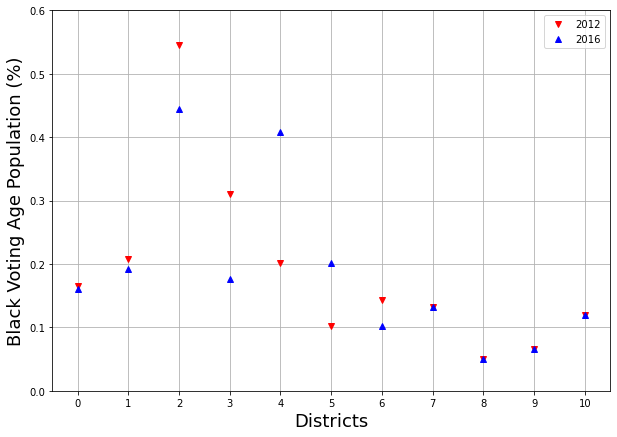

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))

# Draw 50% line
ax.grid()
#ax.axhline(0.5, color="#cccccc")

# Draw boxplot
#black_vpop_constraint.boxplot(ax=ax, positions=range(len(black_vpop_constraint.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
#pd.datafr
plt.plot(black_vpop_normal.iloc[0], "rv", label="2012")
plt.plot(black_vpop_constraint.iloc[0], "b^", label="2016")

# Annotate
ax.set_ylabel("Black Voting Age Population (%)", fontsize=18)
ax.set_xlabel("Districts", fontsize=18)
ax.set_ylim(0, 0.6)
ax.set_yticks(np.arange(0, 0.7, 0.1))
ax.set_xticks(np.arange(0, 11, 1))
plt.legend()
plt.show()

In [149]:
cdf = pd.concat([black_vpop_normal.assign(Constraint="No BVAP Constraint"), black_vpop_constraint.assign(Constraint="BVAP Constraint")]) # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Constraint'], var_name=['Number']) # MELT

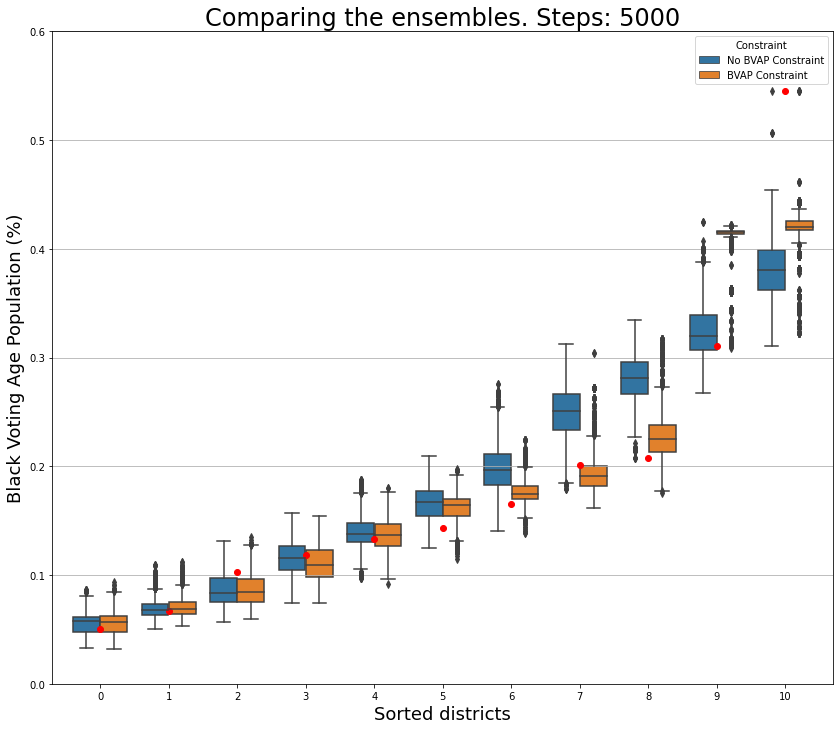

In [150]:
fig, ax = plt.subplots(figsize=(14, 12))

# Draw 50% line
ax.grid()
#ax.axhline(0.5, color="#cccccc")

# Draw boxplot
sns.boxplot(x="Number", y="value", hue="Constraint", data=mdf)

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(black_vpop_normal.iloc[0], "ro")

# Annotate
ax.set_title(f"Comparing the ensembles. Steps: {steps}", fontsize=24)
ax.set_ylabel("Black Voting Age Population (%)", fontsize=18)
ax.set_xlabel("Sorted districts", fontsize=18)
ax.set_ylim(0, 0.6)
ax.set_yticks(np.arange(0, 0.7, 0.1))

plt.show()

In [19]:
for partition in chain_BVAP:
    break


<AxesSubplot:>

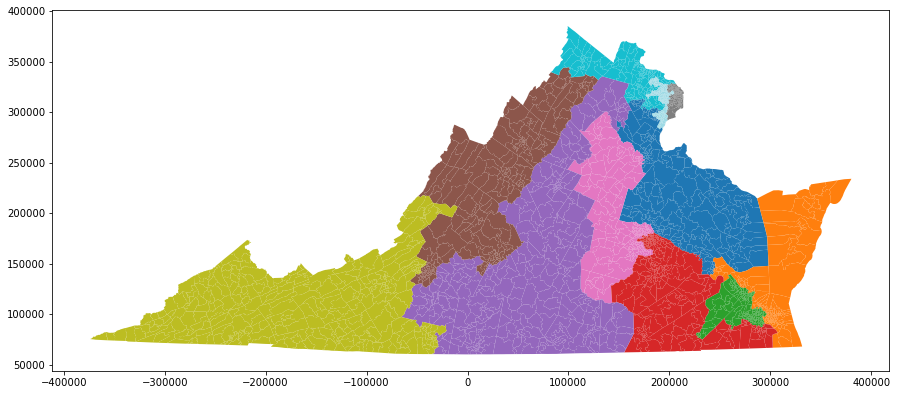

In [20]:
partition.plot(figsize=(15,15), cmap="tab20")

<AxesSubplot:>

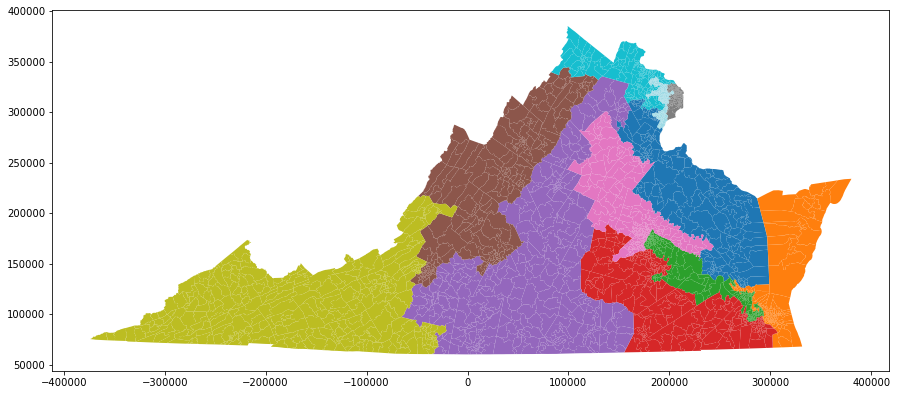

In [18]:
partition.plot(figsize=(15,15), cmap="tab20")

### Checking chain evolution

In [151]:
black_vpop_normal.shape

(5000, 11)

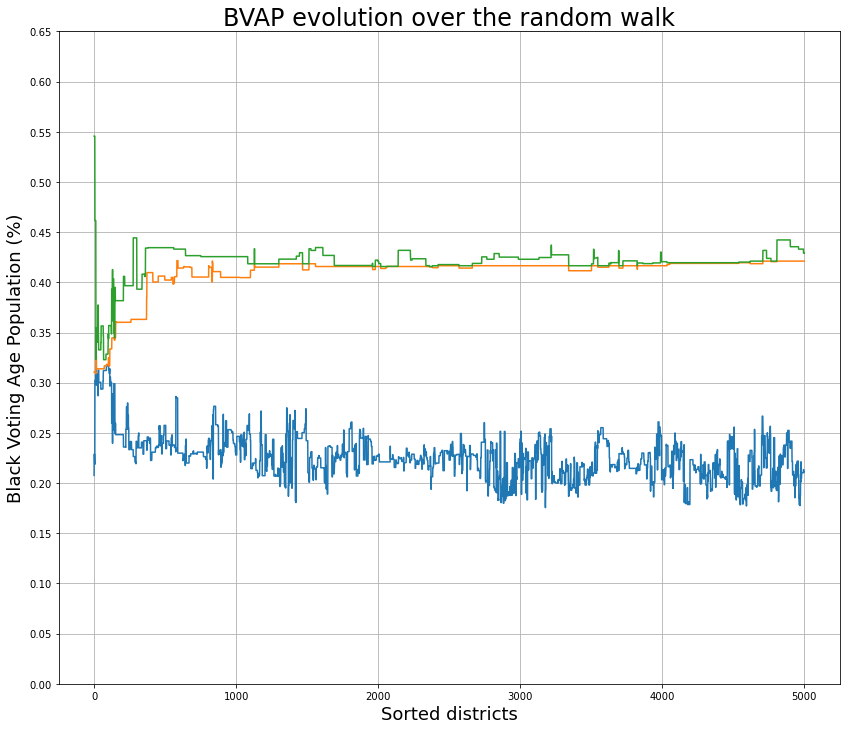

In [154]:
fig, ax = plt.subplots(figsize=(14, 12))

# Draw 50% line
ax.grid()
#ax.axhline(0.5, color="#cccccc")

# Draw boxplot
plt.plot(black_vpop_constraint.iloc[:,-3:])

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)

# Annotate
ax.set_title("BVAP evolution over the random walk", fontsize=24)
ax.set_ylabel("Black Voting Age Population (%)", fontsize=18)
ax.set_xlabel("Sorted districts", fontsize=18)
ax.set_ylim(0, 0.6)
ax.set_yticks(np.arange(0, 0.7, 0.05))

plt.show()



In [85]:
# Run the chain, putting the sorted Asian voting age population percentages
# into a pandas DataFrame for analysis and plotting.
# This will take about 10 minutes.

black_vpop_normal = pd.DataFrame(
    sorted(partition["VPOP"].percents("Black"))
    for partition in chain
)

black_vpop_constraint = pd.DataFrame(
    sorted(partition["VPOP"].percents("Black"))
    for partition in chain
)

In [86]:
cdf = pd.concat([black_vpop_normal.assign(Black=0), black_vpop_constraint.assign(Black=1)]) # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Black'], var_name=['Number']) # MELT

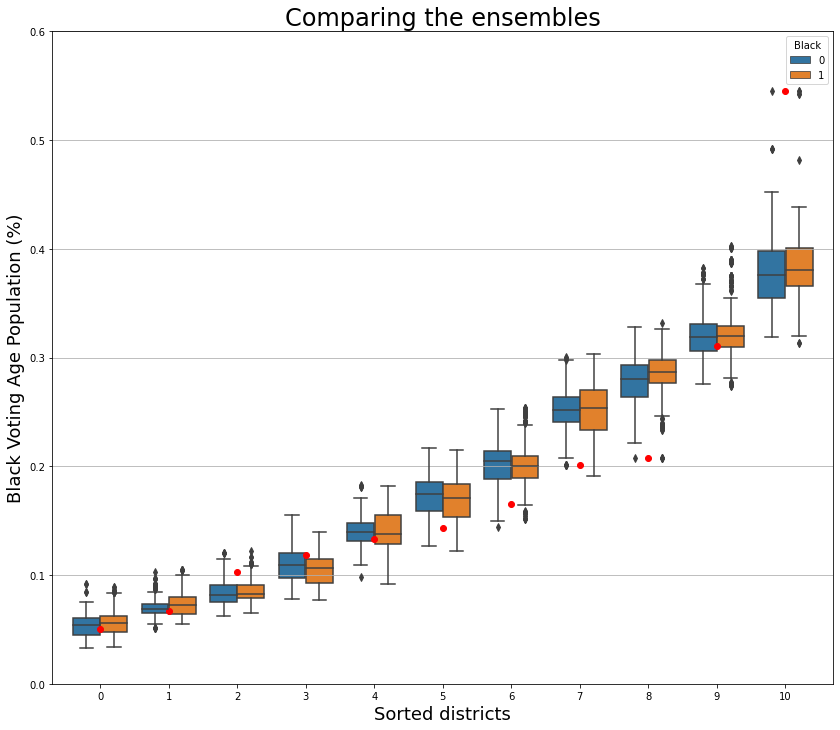

In [87]:
fig, ax = plt.subplots(figsize=(14, 12))

# Draw 50% line
ax.grid()
#ax.axhline(0.5, color="#cccccc")

# Draw boxplot
sns.boxplot(x="Number", y="value", hue="Black", data=mdf)

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(black_vpop_normal.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the ensembles", fontsize=24)
ax.set_ylabel("Black Voting Age Population (%)", fontsize=18)
ax.set_xlabel("Sorted districts", fontsize=18)
ax.set_ylim(0, 0.6)
ax.set_yticks(np.arange(0, 0.7, 0.1))

plt.show()

## Plot

In [66]:
for partition in chain:
    break
    

In [67]:
partition

<GeographicPartition [11 parts]>

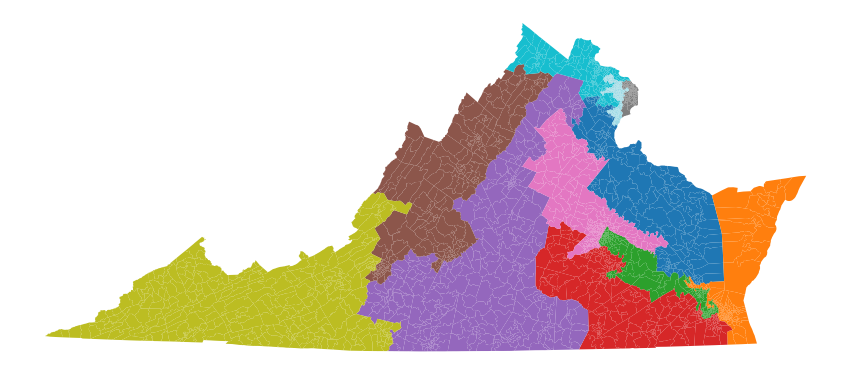

In [70]:
initial_partition.plot(figsize=(15,15), cmap="tab20")
plt.axis('off')
plt.show()

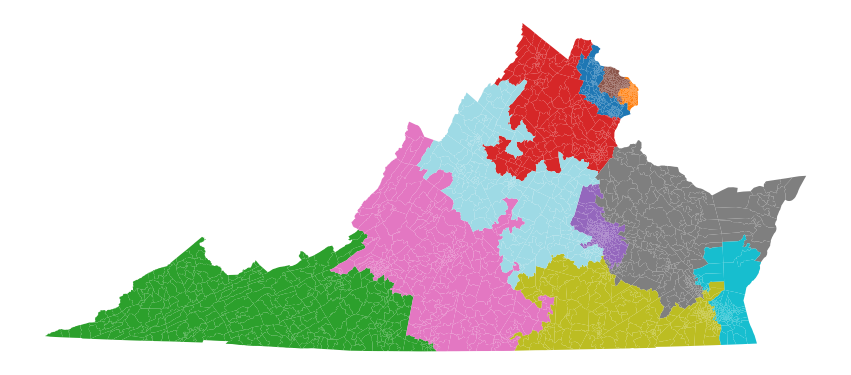

In [68]:
partition.plot(figsize=(15,15), cmap="tab20")
plt.axis('off')
plt.show()

In [83]:
for i in np.array(list(partition['BVAP_population'].values()))/ideal_population:
    print(i*100)

9.231530863703275
10.045839132506362
6.011418038235532
8.91037197818395
23.54179915153335
4.436557116551447
13.41677015630289
21.66323960720213
32.180780877768136
17.170039717264636
9.436242159261967


In [19]:
from .random import random


def always_accept(partition):
    return True


def cut_edge_accept(partition):
    """Always accepts the flip if the number of cut_edges increases.
    Otherwise, uses the Metropolis criterion to decide.

    :param partition: The current partition to accept a flip from.
    :return: True if accepted, False to remain in place

    """
    bound = 1

    if partition.parent is not None:
        bound = min(1, len(partition.parent["cut_edges"]) / len(partition["cut_edges"]))

    return random.random() < bound

ImportError: attempted relative import with no known parent package